<a href="https://colab.research.google.com/github/orntangar/project1/blob/master/Giraud_Nanto_Paper_Dynamics1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-94c3f6f92dfd>:44: RuntimeWarning: invalid value encountered in scalar power
  domega_dt = (1 - omega)**0.1 * omega * phi_lag - omega * alpha
<ipython-input-1-94c3f6f92dfd>:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis", 6)  # Divise en 6 périodes principales


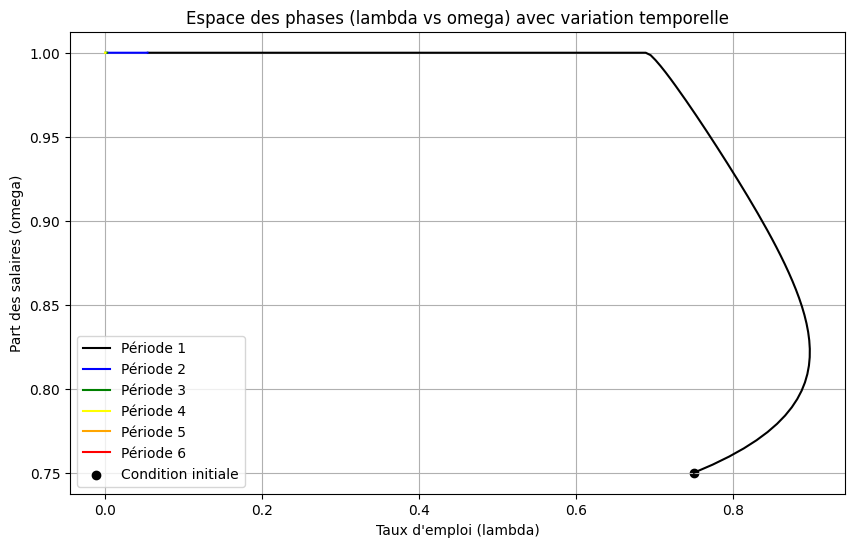

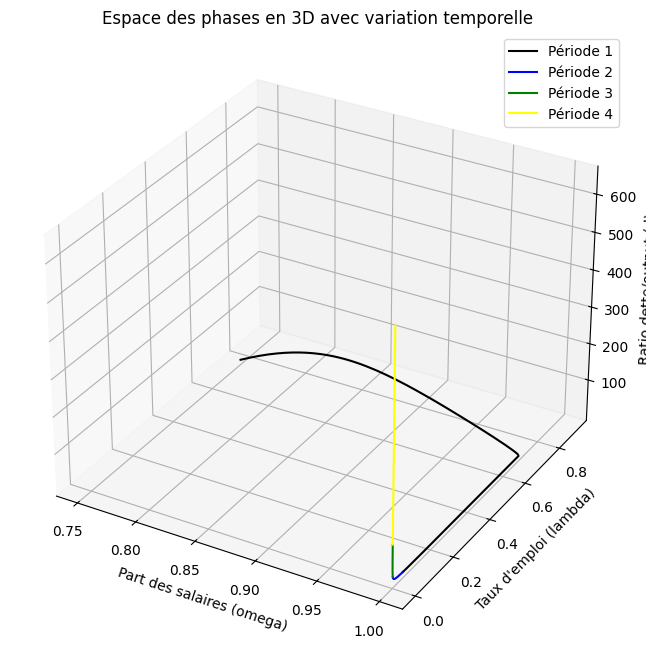

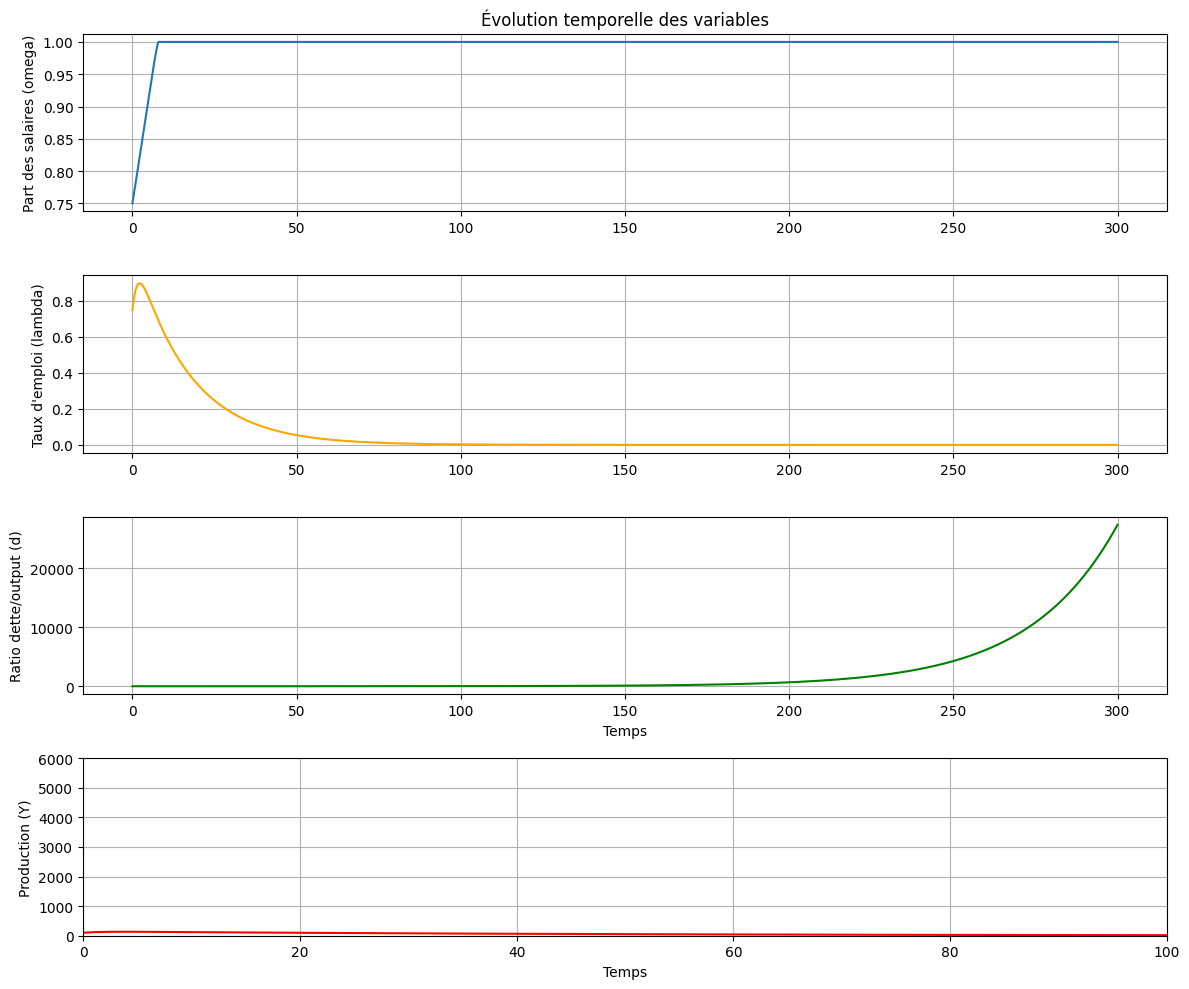

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Paramètres fondamentaux
alpha = 0.02  # Taux de croissance de la productivité
beta = 0.02    # Taux de croissance de la population
nu = 3         # Ratio capital/output
delta = 0.02   # Taux de dépréciation
r = 0.015      # Taux d'intérêt réel

tau = 0  # Retard (en unités de temps)

# Fonction de la courbe de Phillips avec retard
def phi_with_lag(t, lambda_history, t_eval):
    if tau == 0:
        # Pas de retard, on retourne simplement phi(lambda(t))
        return 0.043 / (1 - lambda_history[-1]) - 0.1
    elif t - tau < 0:
        # Si t - tau est négatif, utiliser la valeur initiale de lambda
        return 0.043 / (1 - lambda_history[0]) - 0.1
    else:
        # Trouver l'index correspondant à t - tau
        t_lag = tau
        idx = np.argmin(np.abs(t_eval - t_lag))
        return 0.043 / (1 - lambda_history[idx]) - 0.1

# Fonction d'investissement kappa
kappa = lambda pi: -0.0065 + np.exp(-5) * np.exp(20 * pi)

# Équations différentielles du système

def keen_system(t, y, lambda_history, t_eval):
    omega, lambda_, d, Y = y
    pi = 1 - omega - r * d

    # Assurez-vous que pi reste dans une plage raisonnable
    pi = np.clip(pi, -1e3, 1e3)

    phi_lag = phi_with_lag(t, lambda_history, t_eval)

    domega_dt = (1 - omega)**0.1 * omega * phi_lag - omega * alpha
    dlambda_dt = lambda_ * (kappa(pi) / nu - alpha - beta - delta)
    dd_dt = d * (r - kappa(pi) / nu + delta) + kappa(pi) - (1 - omega)
    dY_dt = Y * (kappa(pi) / nu - delta)

    return [domega_dt, dlambda_dt, dd_dt, dY_dt]

# Conditions initiales
omega0 = 0.75
lambda0 = 0.75
d0 = 0.5
Y0 = 100

# Initialiser correctement les conditions initiales
initial_conditions = [omega0, lambda0, d0, Y0]

# Temps de simulation
t_span = (0, 300)
t_eval = np.linspace(*t_span, 2000)

# Stocker l'historique de lambda
lambda_history = [lambda0] * len(t_eval)

# Fonction pour résoudre le système avec retard
def solve_keen_with_lag():
    lambda_history = [lambda0] * len(t_eval)  # Initialiser avec lambda0

    def keen_system_wrapper(t, y):
        return keen_system(t, y, lambda_history, t_eval)

    solution = solve_ivp(keen_system_wrapper, t_span, initial_conditions, t_eval=t_eval, method='RK45')

    # Mettre à jour l'historique de lambda
    for i, t in enumerate(t_eval):
        lambda_history[i] = solution.y[1][i]

    return solution

# Résolution du système
solution = solve_keen_with_lag()

# Extraction des solutions
omega_sol = solution.y[0]
lambda_sol = solution.y[1]
d_sol = solution.y[2]
Y_sol = solution.y[3]

# Vérification de la stabilité :
if np.any(omega_sol < 0) or np.any(lambda_sol < 0) or np.any(d_sol < 0) or np.any(Y_sol < 0):
    print("Attention : Certaines valeurs deviennent négatives, vérifiez les paramètres !")

# Tracé de l'espace des phases en 2D avec variation de couleur
plt.figure(figsize=(10, 6))
cmap = cm.get_cmap("viridis", 6)  # Divise en 6 périodes principales
segments = len(t_eval) // 6
colors = ["black", "blue", "green","yellow", "orange", "red"]
for i in range(6):
    start = i * segments
    end = (i + 1) * segments if (i + 1) * segments <= len(t_eval) else len(t_eval) - 1
    plt.plot(lambda_sol[start:end], omega_sol[start:end], color=colors[i], label=f"Période {i+1}")
plt.scatter(lambda0, omega0, color='black', label="Condition initiale")
plt.title("Espace des phases (lambda vs omega) avec variation temporelle")
plt.xlabel("Taux d'emploi (lambda)")
plt.ylabel("Part des salaires (omega)")
plt.grid()
plt.legend()
plt.show()

# Tracé de l'espace des phases en 3D avec variation de couleur
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i in range(4):
    start = i * segments
    end = (i + 1) * segments if (i + 1) * segments <= len(t_eval) else len(t_eval) - 1
    ax.plot(omega_sol[start:end], lambda_sol[start:end], d_sol[start:end], color=colors[i], label=f"Période {i+1}")
ax.set_xlabel("Part des salaires (omega)")
ax.set_ylabel("Taux d'emploi (lambda)")
ax.set_zlabel("Ratio dette/output (d)")
ax.set_title("Espace des phases en 3D avec variation temporelle")
ax.legend()
plt.show()

# Tracé des variables au cours du temps
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(t_eval, omega_sol, label="Part des salaires (omega)")
plt.title("Évolution temporelle des variables")
plt.ylabel("Part des salaires (omega)")
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(t_eval, lambda_sol, label="Taux d'emploi (lambda)", color='orange')
plt.ylabel("Taux d'emploi (lambda)")
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(t_eval, d_sol, label="Ratio dette/output (d)", color='green')
plt.xlabel("Temps")
plt.ylabel("Ratio dette/output (d)")
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(t_eval, Y_sol, label="Production (Y)", color='red')
plt.xlabel("Temps")
plt.ylabel("Production (Y)")
plt.ylim(0, 6000)  # Ajuste l'échelle du PIB pour voir les variations
plt.xlim(0,100)  # Ajuste l'échelle de temps pour voir les variations
plt.grid()

plt.tight_layout()
plt.show()
